# CHAPTER 3: A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Ensemble Models**  
Aims:  construct three ensemble techniques: Bagging, Probability averaging, and Concatenation, to further improve prediction accuracy  
* Bagging: use majority voting of top single models  
* Probability averaging: calculate the average probability of the single model prediction results (the last layer of CNN models), and select the largest probability class to be the final class  
* Concatenation: extract the features in the last several layers of single models, and concatenate together to generate the new layers, and add a dense layer to do prediction

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

## Read the test set

In [ ]:
%%time
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './data/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 116919 images belonging to 5 classes.
CPU times: user 2.94 s, sys: 961 ms, total: 3.91 s
Wall time: 3.09 s


In [ ]:
%%time
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


In [ ]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [ ]:
%%time
#read images from validation folder
rootdir = './data/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

3 ./data/test_224/3/458219.png
CPU times: user 326 ms, sys: 42.4 ms, total: 369 ms
Wall time: 365 ms


## Load 5 trained CNN models

In [ ]:
%%time
 #load model 1: xception
xception_model=load_model('./xception.h5')

CPU times: user 1.31 s, sys: 214 ms, total: 1.53 s
Wall time: 1.86 s


In [ ]:
%%time
 #load model 2: VGG16
vgg_model=load_model('./VGG16.h5')

CPU times: user 445 ms, sys: 110 ms, total: 555 ms
Wall time: 717 ms


In [ ]:
%%time
 #load model 3: VGG19
vgg19_model=load_model('./VGG19.h5')

CPU times: user 427 ms, sys: 99.4 ms, total: 526 ms
Wall time: 707 ms


In [ ]:
%%time
 #load model 4: inception
incep_model=load_model('./inception.h5')

CPU times: user 3.05 s, sys: 417 ms, total: 3.47 s
Wall time: 3.94 s


In [ ]:
%%time
 #load model 5: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

CPU times: user 7.12 s, sys: 785 ms, total: 7.9 s
Wall time: 7.73 s


## Use the original CNN base models to make predictions

### 1. Xception

Predicted result for the first image: 3
Confidence level: 0.99999917


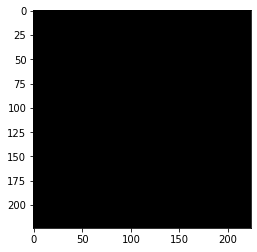

CPU times: user 1.16 s, sys: 30.8 ms, total: 1.19 s
Wall time: 1.47 s


In [ ]:
%%time
#Single image prediction
import cv2
import matplotlib.pyplot as plt
test=cv2.imread(test_images[0])

img_show=test[:,:,[2,1,0]]
test=test/255.
test_shape=(1,)+test.shape
test=test.reshape(test_shape)

res=xception_model.predict(test)

prob=res[0,np.argmax(res,axis=1)[0]]
res=label[np.argmax(res,axis=1)[0]]
print('Predicted result for the first image: %s'%res)
print('Confidence level: %s'%prob)
plt.imshow(img_show)
plt.show()

In [ ]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    xception_model_batch=xception_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=xception_model_batch[0,np.argmax(xception_model_batch,axis=1)[0]]
    res=label[np.argmax(xception_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 1h 52min 10s, sys: 6min 4s, total: 1h 58min 14s
Wall time: 1h 54min 15s


In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[100166      0      0      0      0]
 [     0   4630      0      0      0]
 [     0      0   4322      0      0]
 [     0      0      0   4186      0]
 [     0      0      0      0   3615]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100166
           1       1.00      1.00      1.00      4630
           2       1.00      1.00      1.00      4322
           3       1.00      1.00      1.00      4186
           4       1.00      1.00      1.00      3615

    accuracy                           1.00    116919
   macro avg       1.00      1.00      1.00    116919
weighted avg       1.00      1.00      1.00    116919

CPU times: user 2.05 s, sys: 6.99 ms, total: 2.06 s
Wall time: 2.04 s


### 2. VGG16

In [ ]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg_model_batch,axis=1)[0]]
    predict.append(res)
    

KeyboardInterrupt: ignored

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG16 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

### 3. VGG19

In [ ]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg19_model_batch=vgg19_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg19_model_batch[0,np.argmax(vgg19_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg19_model_batch,axis=1)[0]]
    predict.append(res)
    

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG19 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

### 4. Inception

In [ ]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    incep_model_batch=incep_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=incep_model_batch[0,np.argmax(incep_model_batch,axis=1)[0]]
    res=label[np.argmax(incep_model_batch,axis=1)[0]]
    predict.append(res)
    

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

### 5. InceptionResnet

In [ ]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    inres_model_batch=inres_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=inres_model_batch[0,np.argmax(inres_model_batch,axis=1)[0]]
    res=label[np.argmax(inres_model_batch,axis=1)[0]]
    predict.append(res)
    

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inceptionresnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

### 6. Resnet

In [ ]:
 #load model 6: resnet
res_model=load_model('./resnet.h5')

In [ ]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    res_model_batch=res_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=res_model_batch[0,np.argmax(res_model_batch,axis=1)[0]]
    res=label[np.argmax(res_model_batch,axis=1)[0]]
    predict.append(res)
    

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('resnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Best performing single model (vgg):  
Accuracy: 99.96

# Bagging ensemble

In [ ]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #generate result by model 1
    xception_model_batch=xception_model.predict(np.array(test_batch))
    xception_model_batch=list(np.argmax(xception_model_batch,axis=1))
    xception_model_batch=[label[con] for con in xception_model_batch]
#     print(xception_model_batch)
    #generate result by model 2
    vgg_model_batch=vgg_model.predict(np.array(test_batch))
    vgg_model_batch=list(np.argmax(vgg_model_batch,axis=1))
    vgg_model_batch=[label[con] for con in vgg_model_batch]
#     print(vgg_model_batch)
    #generate result by model 3
    vgg19_model_batch=vgg19_model.predict(np.array(test_batch))
    vgg19_model_batch=list(np.argmax(vgg19_model_batch,axis=1))
    vgg19_model_batch=[label[con] for con in vgg19_model_batch]
#     print(vgg19_model_batch)
    #generate result by model 4
    incep_model_batch=incep_model.predict(np.array(test_batch))
    incep_model_batch=list(np.argmax(incep_model_batch,axis=1))
    incep_model_batch=[label[con] for con in incep_model_batch]
#     print(incep_model_batch)
    #generate result by model 5
    inres_model_batch=inres_model.predict(np.array(test_batch))
    inres_model_batch=list(np.argmax(inres_model_batch,axis=1))
    inres_model_batch=[label[con] for con in inres_model_batch]
#     print(inres_model_batch)
    #bagging the three results generated by 3 singular models
    predict_batch=[]
    for i,j,k,p,q in zip(xception_model_batch,vgg_model_batch,vgg19_model_batch,incep_model_batch,inres_model_batch):
        count=defaultdict(int)
        count[i]+=1
        count[j]+=1
        count[k]+=1
        count[p]+=1
        count[q]+=1
        #rank the predicted results in descending order
        predict_one=sorted(count.items(), key=operator.itemgetter(1),reverse=True)[0][0]
        predict_batch.append(predict_one)
#     print('predict:',predict_batch)
    predict.append(predict_batch)
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
predict=sum(predict,[])

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('bagging accuracy:%s'%acc)

In [ ]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

After bagging ensemble, the accuracy improved to 0.990

# Probability Averaging

In [ ]:
import tensorflow as tf
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout,Average
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
%%time
import time
t1 = time.time()
img=Input(shape=(224,224,3),name='img')
feature1=xception_model(img)
feature2=vgg_model(img)
feature3=incep_model(img)
for layer in xception_model.layers:  
    layer.trainable = False 
for layer in vgg_model.layers:  
    layer.trainable = False  
for layer in incep_model.layers:  
    layer.trainable = False  
output=Average()([feature1,feature2,feature3]) #add the confidence lists generated by 3 models
model=Model(inputs=img,outputs=output)

#the optimization function
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
#read images from validation folder
rootdir = './data/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

In [ ]:
%%time
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    model_batch=model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('Probability Averaging accuracy:%s'%acc)

In [ ]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

# Concatenation

In [ ]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD

In [ ]:
%%time
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(vgg19_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(incep_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(inres_model.layers):
    print(i,layer.name)

### Construct the ensemble model using the last "dense layer" of each base CNN model

In [ ]:
%%time
model1=Model(inputs=[xception_model.layers[0].get_input_at(0)],outputs=xception_model.get_layer('dense_6').output,name='xception')
model2=Model(inputs=[vgg_model.layers[0].get_input_at(0)],outputs=vgg_model.get_layer('dense_8').output,name='vgg')
model3=Model(inputs=[vgg19_model.layers[0].get_input_at(0)],outputs=vgg19_model.get_layer('dense_10').output,name='vgg19')
model4=Model(inputs=[incep_model.layers[0].get_input_at(0)],outputs=incep_model.get_layer('dense_14').output,name='incep')
model5=Model(inputs=[inres_model.layers[0].get_input_at(0)],outputs=inres_model.get_layer('dense_16').output,name='inres')

In [ ]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_accuracy = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_accuracy'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
%%time
ensemble_history= LossHistory()

In [ ]:
%%time
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

In [ ]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [ ]:
%%time
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [ ]:
%%time
def ensemble(num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
    feature2=model2(img)
    feature3=model3(img)
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

In [ ]:
%%time
ensemble_model=ensemble(num_class=5,epochs=20)

In [ ]:
%%time
ensemble_model=load_model('./ensemble.h5')

In [ ]:
%%time
#read images from validation folder
rootdir = './data/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

In [ ]:
%%time
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('Concatenation accuracy:%s'%acc)

In [ ]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))